## Imports

In [ ]:
import numpy as np
import random
import time
import copy
import torch
import gymnasium as gym
import matplotlib.pyplot as plt
import pandas as pd

from evogym.envs import *
from evogym import EvoViewer, get_full_connectivity, sample_robot, is_connected

from neural_controller import NeuralController, set_weights

SEED = [42, 43, 44, 45, 46]


## Utils

In [ ]:
def run_experiment(algorithm, num_runs=5, num_generations=100, scenario='GapJumper-v0',
                   steps=500, algorithm_name=None, SEED=None):
    best_fitnesses_overall = np.zeros(num_generations)
    mean_fitnesses = np.zeros(num_generations)
    std_fitnesses = np.zeros(num_generations)

    total_execution_time = 0
    best_overall_fitness = float('-inf')
    best_overall_weights = None

    if SEED is None:
        SEED = [random.randint(0, 9999) for _ in range(num_runs)]

    for i in range(num_runs):
        seed = SEED[i]
        print(f"\nRunning {algorithm.__name__} {i + 1}/{num_runs} (Seed {seed})...")
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)

        (best_structure, best_weights, best_fitness, best_fitness_scores,
         mean_fitness_scores, exec_time, std_fitness_scores) = algorithm()

        print(f"Best fitness score of run {i + 1}: {best_fitness:.3f}")

        best_fitnesses_overall += np.array(best_fitness_scores)
        mean_fitnesses += np.array(mean_fitness_scores)
        std_fitnesses += np.array(std_fitness_scores)

        if best_fitness > best_overall_fitness:
            best_overall_fitness = best_fitness
            best_overall_weights = best_weights

        # Save individual run CSV
        df = pd.DataFrame({
            'Generation': range(num_generations),
            'Reward': best_fitness_scores,
            'Best Controller Weights': [best_weights] * num_generations,
            'Best Structure': [best_structure.tolist()] * num_generations,
            'Best Fitness': best_fitness_scores,
            'Mean Fitness': mean_fitness_scores,
            'Std Fitness': std_fitness_scores,
            'Execution Time': [exec_time] * num_generations
        })

        algo_name = algorithm_name or algorithm.__name__
        csv_name = f"{algo_name}_{scenario}_seed_{seed}.csv"
        df.to_csv(csv_name, index=False)
        print(f"Saved run {i + 1} results to {csv_name}")

        total_execution_time += exec_time

    # Compute averages
    best_fitnesses_overall /= num_runs
    mean_fitnesses /= num_runs
    std_fitnesses /= num_runs
    mean_exec_time = total_execution_time / num_runs

    print("\nFinal Results After Multiple Runs:")
    print(f"Mean execution time: {mean_exec_time:.2f} seconds")
    print(f"Best fitness found: {best_overall_fitness:.3f}")

    # Save summary CSV
    summary_df = pd.DataFrame({
        'Generation': range(num_generations),
        'Mean Best Fitness': best_fitnesses_overall,
        'Mean Fitness': mean_fitnesses,
        'Std Fitness': std_fitnesses,
        'Mean Execution Time': [mean_exec_time] * num_generations
    })

    summary_csv = f"{algo_name}_{scenario}_summary.csv"
    summary_df.to_csv(summary_csv, index=False)
    print(f"Saved summary results to {summary_csv}")

    # Plot summary
    plt.figure(figsize=(10, 5))
    plt.plot(best_fitnesses_overall, label="Mean Best Fitness", color='blue')
    plt.fill_between(range(num_generations),
                     best_fitnesses_overall - std_fitnesses,
                     best_fitnesses_overall + std_fitnesses,
                     color='blue', alpha=0.2, label='Std Dev Range')
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.title(f"{algo_name}: Fitness Evolution in {scenario}")
    plt.legend()
    plt.grid()
    plt.show()

    return best_overall_weights, best_overall_fitness, best_fitnesses_overall, mean_fitnesses, mean_exec_time, std_fitnesses


## Random Pairing Co-Evolution

In [5]:
# --- PARAMETERS ---
POP_SIZE = 40
NUM_GENERATIONS = 100
STEPS = 500
SCENARIO = 'GapJumper-v0'
ELITE_RATIO = 0.2
VOXEL_TYPES = [0, 1, 2, 3, 4]

# --- ENVIRONMENT SETUP ---
def create_env(structure):
    conn = get_full_connectivity(structure)
    return gym.make(SCENARIO, max_episode_steps=STEPS, body=structure, connections=conn)

# --- Robot utils ---
def create_random_robot():
    while True:
        robot, _ = sample_robot((5, 5))
        if is_connected(robot):
            return robot

def mutate_robot(robot, mutation_rate=0.1):
    new = copy.deepcopy(robot)
    for i in range(new.shape[0]):
        for j in range(new.shape[1]):
            if random.random() < mutation_rate:
                new[i, j] = random.choice(VOXEL_TYPES)
    return new if is_connected(new) else robot

dummy_structure = create_random_robot()
dummy_env = create_env(dummy_structure)
input_size = dummy_env.observation_space.shape[0]
output_size = dummy_env.action_space.shape[0]
dummy_env.close()

brain = NeuralController(input_size, output_size)
shapes = [p.shape for p in brain.parameters()]

# --- HELPERS ---
def vectorize(weights):
    return np.concatenate([w.flatten() for w in weights])

def devectorize(vec, shapes):
    weights, idx = [], 0
    for shape in shapes:
        size = np.prod(shape)
        weights.append(vec[idx:idx + size].reshape(shape))
        idx += size
    return weights


# --- Controller utils ---
def create_random_controller():
    return [np.random.randn(*p.shape) for p in brain.parameters()]

def mutate_controller(controller, std=0.1):
    return [w + np.random.normal(0, std, w.shape) for w in controller]

# --- Crossover ---
def crossover(parent1, parent2):
    child = copy.deepcopy(parent1)
    for i in range(len(parent1)):
        if random.random() < 0.5: # Crossover point
            child[i] = parent2[i]
    return child if is_connected(child) else parent1 # Fallback to parent1

# --- Evaluation ---
def evaluate_fitness(structure, controller, view=False):
    try:
        set_weights(brain, controller)
        env = create_env(structure)
        viewer = EvoViewer(env) if view else None
        if viewer:
            viewer.track_objects('robot')

        state, _ = env.reset()
        total_reward = 0

        for _ in range(STEPS):
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            action = brain(state_tensor).detach().numpy().flatten()
            if view:
                viewer.render('screen')
            state, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward
            if terminated or truncated:
                break

        if viewer: viewer.close()
        env.close()
        return total_reward
    except:
        return 0.0


## RANDOM PAIRING COEVOLUTION
def random_pairing_coevolution():
    # Initialize separate populations
    structures = [create_random_robot() for _ in range(POP_SIZE)]
    controllers = [create_random_controller() for _ in range(POP_SIZE)]

    best_fitness_scores = []
    mean_fitness_scores = []
    std_fitness_scores = []

    best_overall_fitness = float('-inf')
    best_structure = None
    best_controller = None

    start_time = time.time()

    for gen in range(NUM_GENERATIONS):
        pairings = []
        fitnesses = []

        # --- Random pairing: each structure is paired with a random controller
        for i in range(POP_SIZE):
            s = structures[i]
            c = random.choice(controllers)
            fitness = evaluate_fitness(s, c)
            pairings.append((s, c, fitness))
            fitnesses.append(fitness)

        # --- Stats
        best_idx = np.argmax(fitnesses)
        best_s, best_c, best_fit = pairings[best_idx]
        best_fitness_scores.append(best_fit)
        mean_fitness_scores.append(np.mean(fitnesses))
        std_fitness_scores.append(np.std(fitnesses))

        if best_fit > best_overall_fitness:
            best_overall_fitness = float(best_fit)
            best_structure = copy.deepcopy(best_s)
            best_controller = copy.deepcopy(best_c)

        # --- Elitism
        num_elites = int(ELITE_RATIO * POP_SIZE)
        elite_pairings = sorted(pairings, key=lambda x: x[2], reverse=True)[:num_elites]
        elite_structures = [copy.deepcopy(s) for s, _, _ in elite_pairings]
        elite_controllers = [vectorize(c) for _, c, _ in elite_pairings]

        # --- Evolve structures: selection + crossover + mutation
        tournament_size = 3
        selected_structures = []
        for _ in range(POP_SIZE - num_elites):
            contenders = random.sample(pairings, tournament_size)
            winner = max(contenders, key=lambda x: x[2])[0]
            selected_structures.append(winner)

        offspring_structures = []
        for _ in range(POP_SIZE - num_elites):
            p1 = random.choice(selected_structures)
            p2 = random.choice(selected_structures)
            child = crossover(p1, p2)
            child = mutate_robot(child)
            offspring_structures.append(child)

        # --- Evolve controllers using DE
        offspring_controllers = []
        for _ in range(POP_SIZE - num_elites):
            target = random.choice(elite_controllers)
            a, b, c = random.sample(elite_controllers, 3)
            F, CR = 0.6, 0.7
            mutant = a + F * (b - c)
            trial = np.copy(target)
            for i in range(len(trial)):
                if random.random() < CR:
                    trial[i] = mutant[i]
            weights = devectorize(trial, shapes)
            offspring_controllers.append(weights)

        # --- Form new populations
        structures = elite_structures + offspring_structures
        controllers = [devectorize(w, shapes) for w in elite_controllers] + offspring_controllers

    exec_time = time.time() - start_time

    return (
        best_structure,
        best_controller,
        best_overall_fitness,
        best_fitness_scores,
        mean_fitness_scores,
        exec_time,
        std_fitness_scores
    )




Running random_pairing_coevolution 1/5 (Seed 42)...
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
Best fitness score of run 1: 1.705
Saved run 1 results to random_pairing_GapJumper-v0_seed_42.csv

Running random_pairing_coevolution 2/5 (Seed 43)...
Best fitness score of run 2: 2.017
Saved run 2 results to random_pairing_GapJumper-v0_seed_43.csv

Running random_pairing_coevolution 3/5 (Seed 44)...
Best fitness score of run 3: 1.854
Saved run 3 results to random_pairing_GapJumper-v0_seed_44.csv

Running random_pairing_coevolution 4/5 (Seed 45)...
SIMULATION UNSTABLE... TERMINATING
Best fitness score of run 4: 1.618
Saved run 4 results to random_pairing_GapJumper-v0_seed_45.csv

Running random_pairing_coevolution 5/5 (Seed 46)...
SIMULATION UNSTABLE... TERMINATING
Best fitness score of run 5: 1.927
Saved run 5 results to random_pairing_GapJumper-v0_seed_46.csv

Final Results After Multiple Runs:
Mean execution time: 1615.69 seconds
Best fitness found: 2.017
Saved 

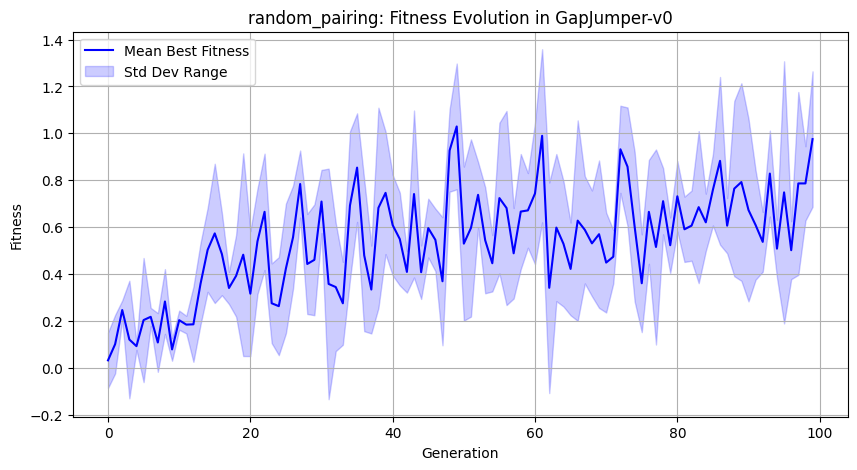

Best fitness: 2.0171557344330617


In [9]:
# Run the experiment with random pairing coevolution
best_w, best_f, bests, means, mean_time, stds = run_experiment(random_pairing_coevolution, num_runs=5, algorithm_name="random_pairing", SEED=SEED)

#print("Best weights:", best_w)
print("Best fitness:", best_f)


Running random_pairing_coevolution 1/5 (Seed 42)...
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
Best fitness score of run 1: 1.705
Saved run 1 results to random_pairing_CaveCrawler-v0_seed_42.csv

Running random_pairing_coevolution 2/5 (Seed 43)...
Best fitness score of run 2: 2.017
Saved run 2 results to random_pairing_CaveCrawler-v0_seed_43.csv

Running random_pairing_coevolution 3/5 (Seed 44)...
Best fitness score of run 3: 1.854
Saved run 3 results to random_pairing_CaveCrawler-v0_seed_44.csv

Running random_pairing_coevolution 4/5 (Seed 45)...
SIMULATION UNSTABLE... TERMINATING
Best fitness score of run 4: 1.618
Saved run 4 results to random_pairing_CaveCrawler-v0_seed_45.csv

Running random_pairing_coevolution 5/5 (Seed 46)...
SIMULATION UNSTABLE... TERMINATING
Best fitness score of run 5: 1.927
Saved run 5 results to random_pairing_CaveCrawler-v0_seed_46.csv

Final Results After Multiple Runs:
Mean execution time: 1621.58 seconds
Best fitness found: 2.

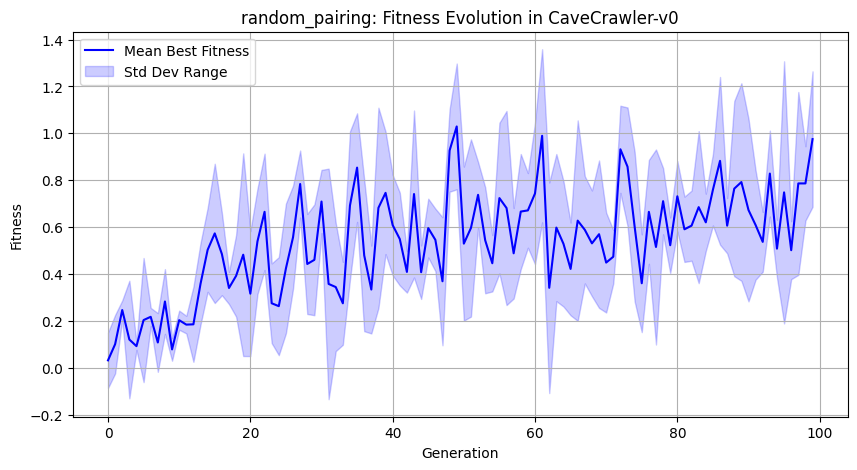

Best fitness: 2.0171557344330617


In [10]:
# Change the scenario
best_w, best_f, bests, means, mean_time, stds = run_experiment(random_pairing_coevolution, num_runs=5, algorithm_name="random_pairing", SEED=SEED, scenario='CaveCrawler-v0')

print("Best fitness:", best_f)

## Best-Of-Opposite Pairing Coevolution

In [3]:
def best_of_opposite_coevolution():
    # Separate structure and controller populations
    structures = [create_random_robot() for _ in range(POP_SIZE)]
    controllers = [create_random_controller() for _ in range(POP_SIZE)]

    best_fitness_scores = []
    mean_fitness_scores = []
    std_fitness_scores = []

    best_overall_fitness = float('-inf')
    best_structure = None
    best_controller = None

    start_time = time.time()

    for gen in range(NUM_GENERATIONS):
        # --- Identify best individuals in each population (evaluate against random partners)
        controller_fitnesses = []
        for c in controllers:
            s = random.choice(structures)
            fitness = evaluate_fitness(s, c)
            controller_fitnesses.append(fitness)
        best_controller = controllers[np.argmax(controller_fitnesses)]

        structure_fitnesses = []
        for s in structures:
            c = random.choice(controllers)
            fitness = evaluate_fitness(s, c)
            structure_fitnesses.append(fitness)
        best_structure = structures[np.argmax(structure_fitnesses)]

        # --- Now evaluate everyone against the *best of opposite population*
        pairings = []
        fitnesses = []

        for s in structures:
            fitness = evaluate_fitness(s, best_controller)
            pairings.append((s, best_controller, fitness))
            fitnesses.append(fitness)

        for c in controllers:
            fitness = evaluate_fitness(best_structure, c)
            pairings.append((best_structure, c, fitness))
            fitnesses.append(fitness)

        # --- Track statistics
        best_idx = np.argmax(fitnesses)
        best_s, best_c, best_fit = pairings[best_idx]
        best_fitness_scores.append(best_fit)
        mean_fitness_scores.append(np.mean(fitnesses))
        std_fitness_scores.append(np.std(fitnesses))

        if best_fit > best_overall_fitness:
            best_overall_fitness = float(best_fit)
            best_structure = copy.deepcopy(best_s)
            best_controller = copy.deepcopy(best_c)

        # --- Elitism
        num_elites = int(ELITE_RATIO * POP_SIZE)
        elite_pairings = sorted(pairings, key=lambda x: x[2], reverse=True)[:num_elites]
        elite_structures = [copy.deepcopy(s) for s, _, _ in elite_pairings]
        elite_controllers = [vectorize(c) for _, c, _ in elite_pairings]

        # --- Evolve structures
        tournament_size = 3
        selected_structures = []
        for _ in range(POP_SIZE - num_elites):
            contenders = random.sample(elite_structures, tournament_size)
            selected_structures.append(max(contenders, key=lambda s: evaluate_fitness(s, best_controller)))

        offspring_structures = []
        for _ in range(POP_SIZE - num_elites):
            p1 = random.choice(selected_structures)
            p2 = random.choice(selected_structures)
            child = crossover(p1, p2)
            child = mutate_robot(child)
            offspring_structures.append(child)

        # --- Evolve controllers using DE
        offspring_controllers = []
        for _ in range(POP_SIZE - num_elites):
            target = random.choice(elite_controllers)
            a, b, c = random.sample(elite_controllers, 3)
            F, CR = 0.6, 0.7
            mutant = a + F * (b - c)
            trial = np.copy(target)
            for i in range(len(trial)):
                if random.random() < CR:
                    trial[i] = mutant[i]
            weights = devectorize(trial, shapes)
            offspring_controllers.append(weights)

        # --- Form next populations
        structures = elite_structures + offspring_structures
        controllers = [devectorize(w, shapes) for w in elite_controllers] + offspring_controllers

    exec_time = time.time() - start_time

    return (
        best_structure,
        best_controller,
        best_overall_fitness,
        best_fitness_scores,
        mean_fitness_scores,
        exec_time,
        std_fitness_scores
    )


In [ ]:
# Run the experiment with best of opposite coevolution
best_w, best_f, bests, means, mean_time, stds = run_experiment(best_of_opposite_coevolution, num_runs=5, algorithm_name="best_of_opposite", SEED=SEED)
print("Best fitness:", best_f)


Running best_of_opposite_coevolution 1/5 (Seed 42)...
Best fitness score of run 1: 1.910
Saved run 1 results to best_of_opposite_GapJumper-v0_seed_42.csv

Running best_of_opposite_coevolution 2/5 (Seed 43)...
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
Best fitness score of run 2: 1.958
Saved run 2 results to best_of_opposite_GapJumper-v0_seed_43.csv

Running best_of_opposite_coevolution 3/5 (Seed 44)...
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
Best fitness score of run 3: 2.083
Saved run 3 results to best_of_opposite_GapJumper-v0_seed_44.csv

Running best_of_opposite_coevolution 4/5 (Seed 45)...
SIMULATION UNSTABLE... TERMINATING


#### PC Went down, and no way i will run everything again


Running best_of_opposite_coevolution 1/2 (Seed 45)...
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
Best fitness score of run 1: 1.959
Saved run 1 results to best_of_opposite_GapJumper-v0_seed_45.csv

Running best_of_opposite_coevolution 2/2 (Seed 46)...
Best fitness score of run 2: 1.328
Saved run 2 results to best_of_opposite_GapJumper-v0_seed_46.csv

Final Results After Multiple Runs:
Mean execution time: 29414.28 seconds
Best fitness found: 1.959


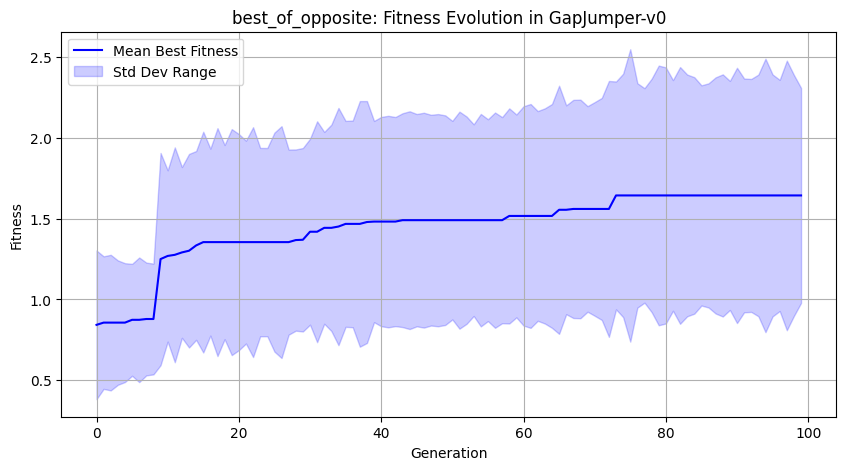

Best fitness: 1.9594195206308613


In [6]:
# Run the experiment with best of opposite coevolution
best_w, best_f, bests, means, mean_time, stds = run_experiment(best_of_opposite_coevolution, num_runs=2, algorithm_name="best_of_opposite", SEED=SEED)
print("Best fitness:", best_f)

In [10]:
# Read the CSV files and make a summary file
def read_csv_files():
    files = ['./results_coevolution/best_of_opposite/gap/best_of_opposite_GapJumper-v0_seed_42.csv',
            './results_coevolution/best_of_opposite/gap/best_of_opposite_GapJumper-v0_seed_43.csv',
            './results_coevolution/best_of_opposite/gap/best_of_opposite_GapJumper-v0_seed_44.csv',
            './results_coevolution/best_of_opposite/gap/best_of_opposite_GapJumper-v0_seed_45.csv',
            './results_coevolution/best_of_opposite/gap/best_of_opposite_GapJumper-v0_seed_46.csv']
    dataframes = []
    for file in files:
        df = pd.read_csv(file)
        dataframes.append(df)
    return pd.concat(dataframes, ignore_index=True)
def save_summary_csv(df):
    summary_df = df.groupby('Generation').agg({
        'Best Fitness': 'mean',
        'Mean Fitness': 'mean',
        'Std Fitness': 'mean',
        'Execution Time': 'mean'
    }).reset_index()

    summary_df.to_csv('./results_coevolution/best_of_opposite/gap/best_of_opposite_GapJumper-v0_summary.csv', index=False)
    print("Summary CSV saved.")
    
# Read the CSV files and save the summary
df = read_csv_files()
save_summary_csv(df)


Summary CSV saved.


In [ ]:
# Change the scenario
best_w, best_f, bests, means, mean_time, stds = run_experiment(best_of_opposite_coevolution, num_runs=5, algorithm_name="best_of_opposite", SEED=SEED, scenario='CaveCrawler-v0')
print("Best fitness:", best_f)

## Shared Evaluation Co-Evolution

In [ ]:
def shared_evaluation_coevolution(num_partners=3):
    structures = [create_random_robot() for _ in range(POP_SIZE)]
    controllers = [create_random_controller() for _ in range(POP_SIZE)]

    best_fitness_scores = []
    mean_fitness_scores = []
    std_fitness_scores = []

    best_overall_fitness = float('-inf')
    best_structure = None
    best_controller = None

    start_time = time.time()

    for gen in range(NUM_GENERATIONS):
        # --- Evaluate each structure with multiple controllers
        structure_fitnesses = []
        for s in structures:
            partners = random.sample(controllers, num_partners)
            fitness_vals = [evaluate_fitness(s, c) for c in partners]
            structure_fitnesses.append(np.mean(fitness_vals))

        # --- Evaluate each controller with multiple structures
        controller_fitnesses = []
        for c in controllers:
            partners = random.sample(structures, num_partners)
            fitness_vals = [evaluate_fitness(s, c) for s in partners]
            controller_fitnesses.append(np.mean(fitness_vals))

        # --- Pairing for next generation: evaluate against random from opposite pop
        pairings = []
        fitnesses = []
        for s in structures:
            c = random.choice(controllers)
            fit = evaluate_fitness(s, c)
            pairings.append((s, c, fit))
            fitnesses.append(fit)
        for c in controllers:
            s = random.choice(structures)
            fit = evaluate_fitness(s, c)
            pairings.append((s, c, fit))
            fitnesses.append(fit)

        # --- Stats
        best_idx = np.argmax(fitnesses)
        best_s, best_c, best_fit = pairings[best_idx]
        best_fitness_scores.append(best_fit)
        mean_fitness_scores.append(np.mean(fitnesses))
        std_fitness_scores.append(np.std(fitnesses))

        if best_fit > best_overall_fitness:
            best_overall_fitness = best_fit
            best_structure = copy.deepcopy(best_s)
            best_controller = copy.deepcopy(best_c)

        # --- Elitism
        num_elites = int(ELITE_RATIO * POP_SIZE)
        elite_pairings = sorted(pairings, key=lambda x: x[2], reverse=True)[:num_elites]
        elite_structures = [copy.deepcopy(s) for s, _, _ in elite_pairings]
        elite_controllers = [vectorize(c) for _, c, _ in elite_pairings]

        # --- Evolve structures (Tournament + Crossover + Mutation)
        selected_structures = []
        for _ in range(POP_SIZE - num_elites):
            contenders = random.sample(elite_structures, 3)
            selected_structures.append(max(contenders, key=lambda s: evaluate_fitness(s, random.choice(controllers))))

        offspring_structures = []
        for _ in range(POP_SIZE - num_elites):
            p1, p2 = random.choice(selected_structures), random.choice(selected_structures)
            child = crossover(p1, p2)
            offspring_structures.append(mutate_robot(child))

        # --- Evolve controllers using DE
        offspring_controllers = []
        for _ in range(POP_SIZE - num_elites):
            target = random.choice(elite_controllers)
            a, b, c = random.sample(elite_controllers, 3)
            F, CR = 0.6, 0.7
            mutant = a + F * (b - c)
            trial = np.copy(target)
            for i in range(len(trial)):
                if random.random() < CR:
                    trial[i] = mutant[i]
            weights = devectorize(trial, shapes)
            offspring_controllers.append(weights)
            
        # Print best fitness
        print(f"Generation {gen}: Best fitness = {best_fit:.3f}")

        # --- Next gen
        structures = elite_structures + offspring_structures
        controllers = [devectorize(w, shapes) for w in elite_controllers] + offspring_controllers

    exec_time = time.time() - start_time
    return best_structure, best_controller, best_overall_fitness, best_fitness_scores, mean_fitness_scores, exec_time, std_fitness_scores


In [ ]:
# Run the experiment with shared evaluation coevolution
best_w, best_f, bests, means, mean_time, stds = run_experiment(shared_evaluation_coevolution, num_runs=5, algorithm_name="shared_evaluation", SEED=SEED)
print("Best fitness:", best_f)


Running shared_evaluation_coevolution 1/5 (Seed 42)...


In [ ]:
# Change the scenario
best_w, best_f, bests, means, mean_time, stds = run_experiment(shared_evaluation_coevolution, num_runs=5, algorithm_name="shared_evaluation", SEED=SEED, scenario='CaveCrawler-v0')

## Alternating Coevolution

In [ ]:
def alternating_coevolution():
    structures = [create_random_robot() for _ in range(POP_SIZE)]
    controllers = [create_random_controller() for _ in range(POP_SIZE)]

    best_fitness_scores = []
    mean_fitness_scores = []
    std_fitness_scores = []

    best_overall_fitness = float('-inf')
    best_structure = None
    best_controller = None

    start_time = time.time()

    alternate = True
    for gen in range(NUM_GENERATIONS):
        fitnesses = []
        pairings = []

        # Maybe instead of alternating gen by gen, we can alternate every 5 generations
        if gen % 2 == 0:
            # Evolve structures against fixed controllers
            fixed_controllers = copy.deepcopy(controllers)
            for s in structures:
                c = random.choice(fixed_controllers)
                fit = evaluate_fitness(s, c)
                pairings.append((s, c, fit))
                fitnesses.append(fit)
        else:
            # Evolve controllers against fixed structures
            fixed_structures = copy.deepcopy(structures)
            for c in controllers:
                s = random.choice(fixed_structures)
                fit = evaluate_fitness(s, c)
                pairings.append((s, c, fit))
                fitnesses.append(fit)

        best_idx = np.argmax(fitnesses)
        best_s, best_c, best_fit = pairings[best_idx]
        best_fitness_scores.append(best_fit)
        mean_fitness_scores.append(np.mean(fitnesses))
        std_fitness_scores.append(np.std(fitnesses))

        if best_fit > best_overall_fitness:
            best_overall_fitness = best_fit
            best_structure = copy.deepcopy(best_s)
            best_controller = copy.deepcopy(best_c)

        num_elites = int(ELITE_RATIO * POP_SIZE)
        elite_pairings = sorted(pairings, key=lambda x: x[2], reverse=True)[:num_elites]
        elite_structures = [copy.deepcopy(s) for s, _, _ in elite_pairings]
        elite_controllers = [vectorize(c) for _, c, _ in elite_pairings]

        if gen % 2 == 0:
            # Evolve structures
            selected = []
            for _ in range(POP_SIZE - num_elites):
                contenders = random.sample(elite_structures, 3)
                selected.append(max(contenders, key=lambda s: evaluate_fitness(s, random.choice(controllers))))
            offspring = []
            for _ in range(POP_SIZE - num_elites):
                p1, p2 = random.choice(selected), random.choice(selected)
                child = crossover(p1, p2)
                offspring.append(mutate_robot(child))
            structures = elite_structures + offspring
        else:
            # --- Evolve controllers using DE
            offspring_controllers = []
            for _ in range(POP_SIZE - num_elites):
                target = random.choice(elite_controllers)
                a, b, c = random.sample(elite_controllers, 3)
                F, CR = 0.6, 0.7
                mutant = a + F * (b - c)
                trial = np.copy(target)
                for i in range(len(trial)):
                    if random.random() < CR:
                        trial[i] = mutant[i]
                weights = devectorize(trial, shapes)
                offspring_controllers.append(weights)
            controllers = [devectorize(w, shapes) for w in elite_controllers] + offspring_controllers

    exec_time = time.time() - start_time
    return best_structure, best_controller, best_overall_fitness, best_fitness_scores, mean_fitness_scores, exec_time, std_fitness_scores



Running alternating_coevolution 1/5 (Seed 42)...
Best fitness score of run 1: 0.854
Saved run 1 results to alternating_GapJumper-v0_seed_42.csv

Running alternating_coevolution 2/5 (Seed 43)...
Best fitness score of run 2: 1.765
Saved run 2 results to alternating_GapJumper-v0_seed_43.csv

Running alternating_coevolution 3/5 (Seed 44)...
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINA

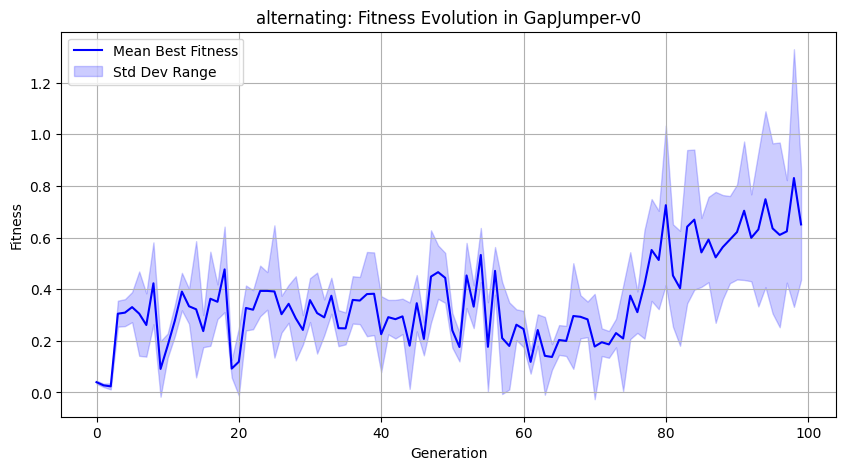

Best fitness: 1.9855986354445254


In [6]:
# Run the experiment with alternating coevolution
best_w, best_f, bests, means, mean_time, stds = run_experiment(alternating_coevolution, num_runs=5, algorithm_name="alternating", SEED=SEED)
print("Best fitness:", best_f)


Running alternating_coevolution 1/5 (Seed 42)...
Best fitness score of run 1: 0.854
Saved run 1 results to alternating_CaveCrawler-v0_seed_42.csv

Running alternating_coevolution 2/5 (Seed 43)...
Best fitness score of run 2: 1.765
Saved run 2 results to alternating_CaveCrawler-v0_seed_43.csv

Running alternating_coevolution 3/5 (Seed 44)...
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TER

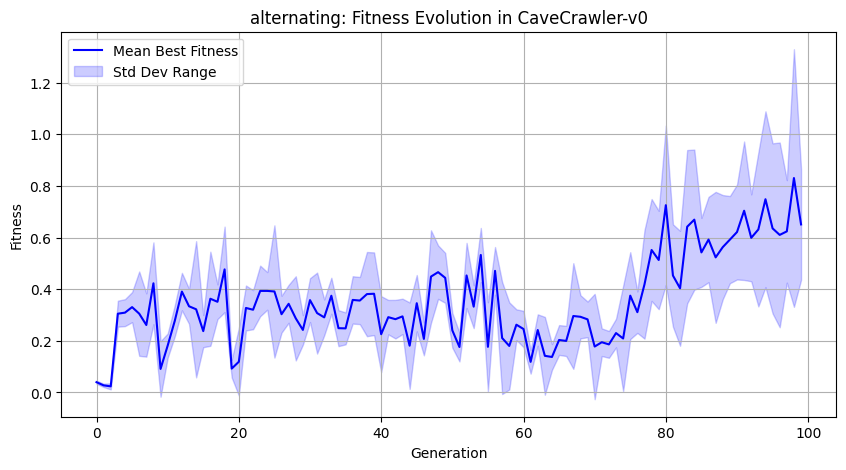

In [7]:
# Change the scenario
best_w, best_f, bests, means, mean_time, stds = run_experiment(alternating_coevolution, num_runs=5, algorithm_name="alternating", SEED=SEED, scenario='CaveCrawler-v0')

## Bias Alternating Coevolution

The controllers are more difficult to evolve, so lets be bias and give more generations 

In [4]:
def biased_alternating_coevolution():
    structures = [create_random_robot() for _ in range(POP_SIZE)]
    controllers = [create_random_controller() for _ in range(POP_SIZE)]

    best_fitness_scores = []
    mean_fitness_scores = []
    std_fitness_scores = []

    best_overall_fitness = float('-inf')
    best_structure = None
    best_controller = None

    start_time = time.time()
    phase = 0  # used to control biased alternation: 0 = structure, 1–3 = controllers

    for gen in range(NUM_GENERATIONS):
        fitnesses = []
        pairings = []

        if phase == 0:
            # --- Evolve structures against fixed controllers
            fixed_controllers = copy.deepcopy(controllers)
            for s in structures:
                c = random.choice(fixed_controllers)
                fit = evaluate_fitness(s, c)
                pairings.append((s, c, fit))
                fitnesses.append(fit)
        else:
            # --- Evolve controllers against fixed structures
            fixed_structures = copy.deepcopy(structures)
            for c in controllers:
                s = random.choice(fixed_structures)
                fit = evaluate_fitness(s, c)
                pairings.append((s, c, fit))
                fitnesses.append(fit)

        # --- Update statistics
        best_idx = np.argmax(fitnesses)
        best_s, best_c, best_fit = pairings[best_idx]
        best_fitness_scores.append(best_fit)
        mean_fitness_scores.append(np.mean(fitnesses))
        std_fitness_scores.append(np.std(fitnesses))

        if best_fit > best_overall_fitness:
            best_overall_fitness = best_fit
            best_structure = copy.deepcopy(best_s)
            best_controller = copy.deepcopy(best_c)

        # --- Elitism
        num_elites = int(ELITE_RATIO * POP_SIZE)
        elite_pairings = sorted(pairings, key=lambda x: x[2], reverse=True)[:num_elites]
        elite_structures = [copy.deepcopy(s) for s, _, _ in elite_pairings]
        elite_controllers = [vectorize(c) for _, c, _ in elite_pairings]

        if phase == 0:
            # --- Evolve structures
            selected = []
            for _ in range(POP_SIZE - num_elites):
                contenders = random.sample(elite_structures, 3)
                selected.append(max(contenders, key=lambda s: evaluate_fitness(s, random.choice(controllers))))
            offspring = []
            for _ in range(POP_SIZE - num_elites):
                p1, p2 = random.choice(selected), random.choice(selected)
                child = crossover(p1, p2)
                offspring.append(mutate_robot(child))
            structures = elite_structures + offspring
        else:
            # --- Evolve controllers using DE
            offspring_controllers = []
            for _ in range(POP_SIZE - num_elites):
                target = random.choice(elite_controllers)
                a, b, c = random.sample(elite_controllers, 3)
                F, CR = 0.5, 0.6
                mutant = a + F * (b - c)
                trial = np.copy(target)
                for i in range(len(trial)):
                    if random.random() < CR:
                        trial[i] = mutant[i]
                weights = devectorize(trial, shapes)
                offspring_controllers.append(weights)
            controllers = [devectorize(w, shapes) for w in elite_controllers] + offspring_controllers

        # --- Update phase for biased alternation (1 structure : 3 controllers)
        phase = (phase + 1) % 4

    exec_time = time.time() - start_time
    return best_structure, best_controller, best_overall_fitness, best_fitness_scores, mean_fitness_scores, exec_time, std_fitness_scores



Running biased_alternating_coevolution 1/5 (Seed 42)...
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
Best fitness score of run 1: 1.287
Saved run 1 results to alternating_bias_GapJumper-v0_seed_42.csv

Running biased_alternating_coevolution 2/5 (Seed 43)...
Best fitness score of run 2: 1.919
Saved run 2 results to alternating_bias_GapJumper-v0_seed_43.csv

Running biased_alternating_coevolution 3/5 (Seed 44)...

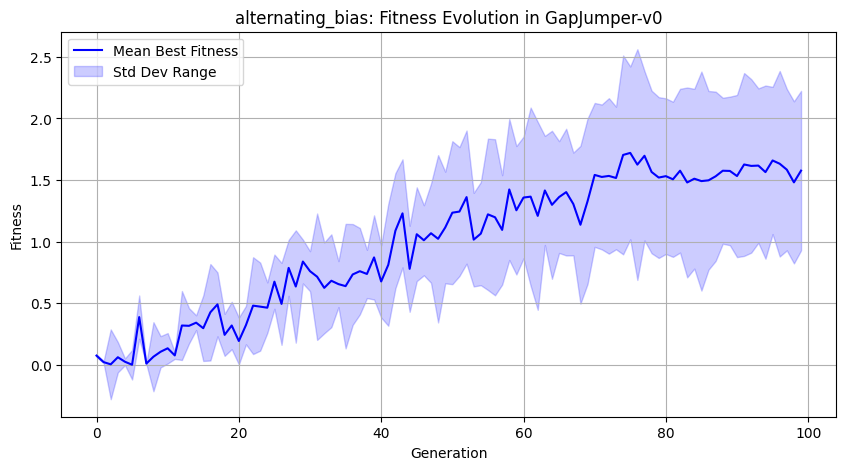

Best fitness: 2.129286507228816


In [5]:
# Run the experiment with alternating coevolution
best_w, best_f, bests, means, mean_time, stds = run_experiment(biased_alternating_coevolution, num_runs=5, algorithm_name="alternating_bias", SEED=SEED)
print("Best fitness:", best_f)


Running biased_alternating_coevolution 1/5 (Seed 42)...
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
Best fitness score of run 1: 1.287
Saved run 1 results to alternating_bias_CaveCrawler-v0_seed_42.csv

Running biased_alternating_coevolution 2/5 (Seed 43)...
Best fitness score of run 2: 1.919
Saved run 2 results to alternating_bias_CaveCrawler-v0_seed_43.csv

Running biased_alternating_coevolution 3/5 (Seed 44

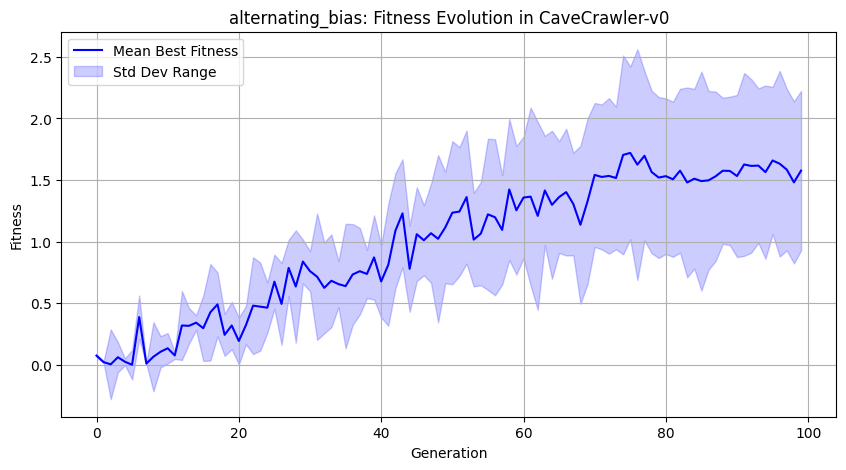

Best fitness: 2.129286507228816


In [6]:
# Change the scenario
best_w, best_f, bests, means, mean_time, stds = run_experiment(biased_alternating_coevolution, num_runs=5, algorithm_name="alternating_bias", SEED=SEED, scenario='CaveCrawler-v0')
print("Best fitness:", best_f)